In [1]:
# Copyright 2018 The Sonnet Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or  implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================


# Borrowed from https://github.com/deepmind/sonnet and ported it to PyTorch

In [10]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [11]:
import gc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#import umap

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

#import librosa, librosa.display

from vq_vae_2 import Model

from tqdm.notebook import tqdm

In [12]:
seed = 0
epochs = 3000
batch_size = 8
learning_rate = 2e-5
num_hiddens = 128 #128
num_residual_hiddens = 32
num_residual_layers = 4
embedding_dim = 64 #64
num_embeddings = 512 #512
commitment_cost = 0.25
print_every = 100

# data_variance, data_mean, data_std = 298.7436551399305, -42.99114339002469, 17.284202473354984

In [13]:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
#device = torch.device('cpu')

In [15]:
device

device(type='cuda')

In [16]:
EMO_PATH = "./mean_data.csv"
MEL_ARR_PATH = "./split_mel_array"
SAVE_PATH = "./save_models"

In [26]:
class MelData(Dataset):
    def __init__(self, file_path):
        self.data = []
        genre = ['classical', 'rock', 'electronic', 'pop', 'deam']
        
        for g in genre:
            for i in range(1, 101):
                for j in range(100):
                    tmp_path = f'{file_path}/{g}/{i}-{j}.csv'
                    try:
                        self.data.append((pd.read_csv(tmp_path).iloc[:, :512].values, g, i, j))
                    except FileNotFoundError:
                        continue
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        mel, g, i, j = self.data[idx]
        mel = torch.from_numpy(pd.get_dummies(mel).values)
        mel = mel.type(torch.cuda.FloatTensor)
        
        return (g, i, j), mel

class EmotionalData(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        tmp_data = self.data.iloc[idx]
        genre, idx = tmp_data[0].split('_')
        emo = tmp_data[1:]
        return idx, genre, torch.FloatTensor(emo)

In [27]:
mel_arr_data = MelData(MEL_ARR_PATH)
#emo_data = EmotionalData(EMO_PATH)

In [28]:
mel_arr_data_loader = DataLoader(
        dataset=mel_arr_data, batch_size=batch_size, shuffle=True)

#emo_data_loader = DataLoader(
#        dataset=emo_data, batch_size=batch_size, shuffle=True)

In [29]:
# data_variance = np.var(np.array([x[0] for x in mel_arr_data.data]) / 80)
data_variance = 0.04667869611561432

TypeError: unsupported operand type(s) for /: 'list' and 'float'

In [13]:
model = Model().to(device)

optimizer = optim.RAdam(model.parameters(), lr=learning_rate)

train_recon_err = []
train_perplexity = []

gc.collect()

19

In [14]:
import importlib
import vq_vae_2
importlib.reload(vq_vae_2)
from vq_vae_2 import Model

model = Model().to(device)

In [21]:
# test model

# display(model)
with torch.no_grad():
    test_x = torch.rand(1, 1, 80, 1024).to(device)
    print(test_x.size())
    print(model(test_x)[1].size())
    q_t, q_b, _, _, ids_t, ids_b = model.encode(test_x)
    print(q_b.shape, q_t.shape, ids_t.shape, ids_b.shape)

torch.Size([1, 1, 80, 1024])
torch.Size([1, 1, 80, 1024])
torch.Size([1, 64, 10, 128]) torch.Size([1, 64, 5, 64]) torch.Size([1, 5, 64]) torch.Size([1, 10, 128])


In [16]:
model = Model(num_hiddens=num_hiddens, 
                  num_residual_layers=num_residual_layers,
                  num_residual_hiddens=num_residual_hiddens,
                  num_embeddings=num_embeddings,
                  embedding_dim=embedding_dim, 
                  commitment_cost=commitment_cost).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_recon_err = []
train_perplexity = []

gc.collect()

54

In [17]:
def scaled(x):
    return (x + 80.0) / 160.0
def unscaled(x):
    return x * 160.0 - 80.0

In [18]:
z = torch.rand(320, 512).to(device)

for epoch in tqdm(range(epochs)):
    for iteration, (_, x) in enumerate(mel_arr_data_loader):
        # emo data
        #_, _, c = next(iter(emo_data_loader))
        
        x = scaled(x)
        x = x[:, :, :-4].unsqueeze(1)
        x = x.to(device)
        
        optimizer.zero_grad()

        vq_loss, x_recon, perplexity = model(x)
        recon_error = F.mse_loss(x_recon, x) / data_variance
        loss = recon_error + vq_loss
        loss.backward()

        optimizer.step()
        
    if (epoch) % 100 == 0:
        print(f"epochs:\t{epoch}")
        print(f"loss:\t{loss.item(): .3f}")
        print(f"recon_error:\t{np.mean(train_recon_err[-len(mel_arr_data_loader)+1:]): .3f}")
        print(f"perplexity:\t{np.mean(train_perplexity[-len(mel_arr_data_loader)+1:]): .3f}")
        print(f"vq_loss:\t{vq_loss.item(): .3f}")

        with torch.no_grad():
            # torch.Size([32, 5, 64, 4]) 32, 5, 64, 128
            # torch.Size([10240, 1024])
            _, x = mel_arr_data[0]
            x = scaled(x)
            x.to(device)
            _, x_recon, _ = model(x[:,:-4])
            
            x = x.detach().cpu().numpy()
            fig = plt.figure(figsize=(15, 9))
            plt.subplot(211)
            librosa.display.specshow(unscaled(x), sr=22050, hop_length=256)
            
            x_recon = x_recon.reshape(1, 1, 80, 1024).squeeze().detach().cpu().numpy()
            plt.subplot(212)
            librosa.display.specshow(unscaled(x), sr=22050, hop_length=256)

            fig.savefig(f"outputs/vqvae2/{epoch}.png")
            plt.close()

        print()
    train_recon_err.append(recon_error.item())
    train_perplexity.append(perplexity.item())

  0%|          | 0/3000 [00:00<?, ?it/s]

epochs:	0
loss:	 1989.601
recon_error:	 nan
perplexity:	 nan
vq_loss:	 247.601


/home/gibeom/.conda/envs/audio/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gibeom/.conda/envs/audio/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



epochs:	100
loss:	 2238.537
recon_error:	 584.454
perplexity:	 290.384
vq_loss:	 1921.876

epochs:	200
loss:	 2326.645
recon_error:	 438.510
perplexity:	 370.502
vq_loss:	 2005.584

epochs:	300
loss:	 2579.937
recon_error:	 293.167
perplexity:	 485.487
vq_loss:	 2323.239

epochs:	400
loss:	 2522.818
recon_error:	 258.963
perplexity:	 565.468
vq_loss:	 2266.410

epochs:	500
loss:	 2720.938
recon_error:	 238.197
perplexity:	 617.715
vq_loss:	 2454.044



KeyboardInterrupt: 

Text(0.5, 0, 'iteration')

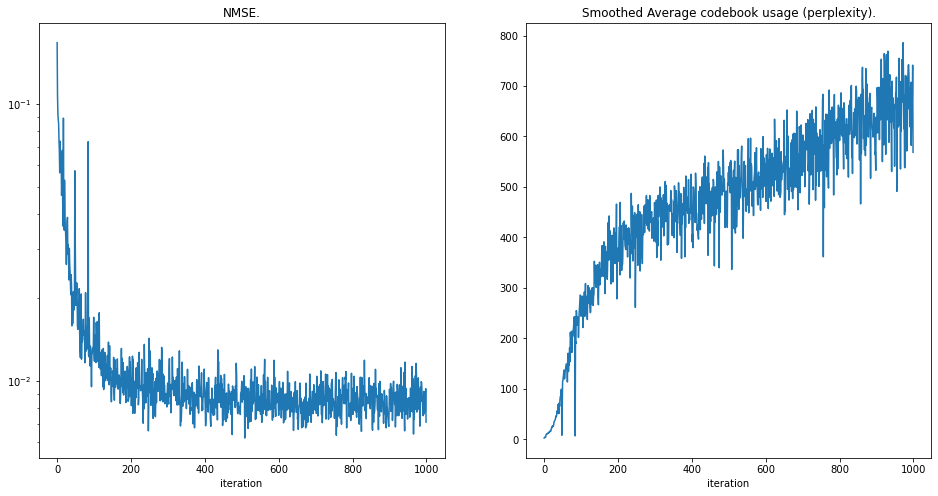

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_recon_err)
ax.set_yscale('log')
ax.set_title('NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)

ax.plot(train_perplexity)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [19]:
# 79.84939575195312
min_err = min(train_recon_err)
# torch.save(model, f'{SAVE_PATH}/vqvae2-{min_err:.5f}.pt')
torch.save(model.state_dict(), f'{SAVE_PATH}/vqvae2_light-{min_err:.5f}_dict.pt')
print(min_err)

163.6425323486328


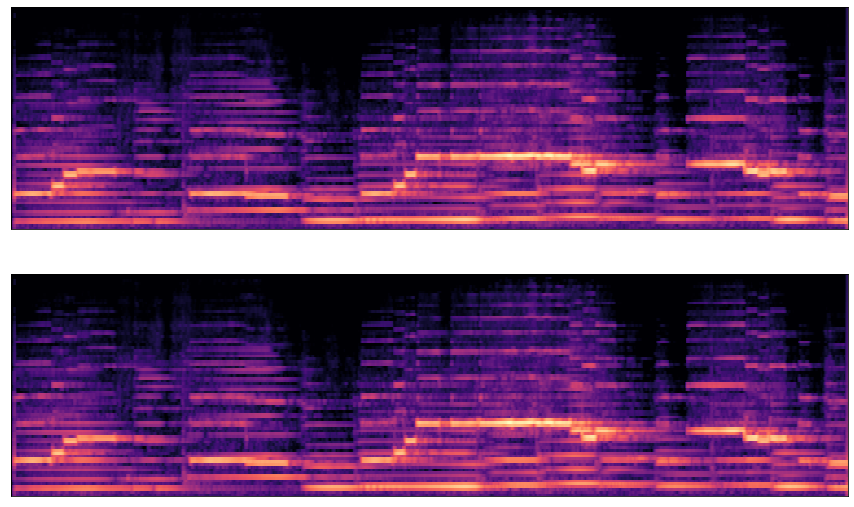

In [20]:
import soundfile
with torch.no_grad():
    # torch.Size([32, 5, 64, 4]) 32, 5, 64, 128
    # torch.Size([10240, 1024])
    _, x = mel_arr_data[0]
    out = librosa.db_to_power((x).detach().cpu().numpy(), ref=80)
    y = librosa.feature.inverse.mel_to_audio(out, sr=22050, n_fft=2048, hop_length=256)
    soundfile.write("sample/origin_audio.wav", y, 22050, format='WAV')
    x = scaled(x)
    x.to(device)
    _, x_recon, _ = model(x[:,:-4].reshape(1, 1, 320, 256))
    
    x = x.detach().cpu().numpy()
    fig = plt.figure(figsize=(15, 9))
    plt.subplot(211)
    librosa.display.specshow(unscaled(x), sr=22050, hop_length=256)
    
    x_recon = x_recon.reshape(1, 1, 80, 1024).squeeze().detach().cpu().numpy()
    plt.subplot(212)
    librosa.display.specshow(unscaled(x), sr=22050, hop_length=256)
    
    out = librosa.db_to_power(unscaled(x), ref=80)
    y = librosa.feature.inverse.mel_to_audio(out, sr=22050, n_fft=2048, hop_length=256)
    soundfile.write("sample/recon_audio.wav", y, 22050, format='WAV')

In [ ]:
model = Model(num_hiddens=num_hiddens, 
                  num_residual_layers=num_residual_layers,
                  num_residual_hiddens=num_residual_hiddens,
                  num_embeddings=num_embeddings,
                  embedding_dim=embedding_dim, 
                  commitment_cost=commitment_cost).to(device)
score = 0.0063145775347948074
PATH = f'{SAVE_PATH}/vqvae2_light-{score:.5f}_dict.pt'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>